In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import collections
import ipynb.fs.full.Structural_Perturbations as SP
import ipynb.fs.full.MultiTest as MT
tf.logging.set_verbosity(tf.logging.INFO)
import sys

/home/uttaran/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/uttaran/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Data has apparently already been downloaded and unpacked.


Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
0.76470596


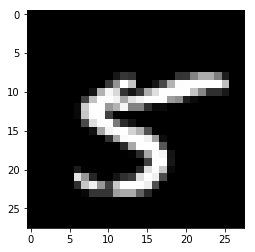

In [2]:
train_data,train_labels,eval_data,eval_labels = SP.load(data='mnist')
SP.Display(eval_data,433)
print(eval_data[1000][433])

In [16]:
eval_data = SP.Scaling(eval_data,.8)

In [18]:
eval_data = Exposure(eval_data,+60)

In [6]:
eval_data = SP.Rotation(eval_data,30)

In [69]:
eval_data = Translation(eval_data,2)

In [3]:
train_labels = np.copy(train_data)
randm = np.random.choice(55000,40000,replace=False)
i=0
while i in range(0,randm.shape[0]-8):
    train_data[randm[i]] = SP.Exposure(train_data[randm[i]],60)
    train_data[randm[i+1]] = SP.Rotation(train_data[randm[i+1]],30)
    train_data[randm[i+2]] = SP.Translation(train_data[randm[i+2]],2)
    train_data[randm[i+3]] = SP.Scaling(train_data[randm[i+3]],0.6)
    train_data[randm[i+4]] = SP.Exposure(train_data[randm[i+4]],-60)
    train_data[randm[i+5]] = SP.Rotation(train_data[randm[i+5]],-30)
    train_data[randm[i+6]] = SP.Scaling(train_data[randm[i+6]],1.5)
    train_data[randm[i+7]] = SP.Translation(train_data[randm[i+7]],2)
    i+=8

In [4]:
train_data = SP.Exposure(train_data,60)

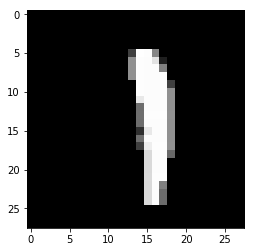

In [4]:
SP.Display(train_data,33337)

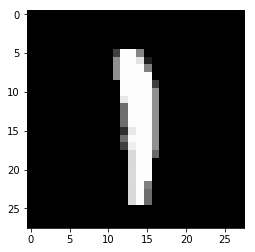

In [5]:
SP.Display(train_labels,33337)

In [6]:
train_labels = train_labels.reshape(-1,28,28,1)

In [12]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=4,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    
    pool1 = tf.contrib.layers.max_pool2d(inputs=conv1, kernel_size=2)
    
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=8,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    
    pool2 = tf.contrib.layers.max_pool2d(inputs=conv2,  kernel_size=2)
    
    conv3 = tf.layers.conv2d(
        inputs=pool2,
        filters=16,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    
    pool3 = tf.contrib.layers.max_pool2d(inputs=conv3,  kernel_size=2)
    
#     print(pool3.shape)
    
    conv4 = tf.layers.conv2d_transpose(
        inputs=pool3,
        filters=16,
        strides = 2,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    
    conv5 = tf.layers.conv2d_transpose(
        inputs=conv4,
        filters=8,
        strides = 2,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    
    conv6 = tf.layers.conv2d_transpose(
        inputs=conv5,
        filters=4,
        strides = 2,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
#     print(conv6.shape)

    conv7 = tf.layers.conv2d_transpose(
        inputs=conv6,
        filters=1,
        kernel_size=[3, 3],
        padding="same",
        activation=None)
    
#     print(conv7.shape)
    
    paddings = tf.constant([[0, 0,], [2, 2],[2,2],[0,0]])

    conv7 = tf.pad(conv7, paddings, "CONSTANT") 
    
#     print(conv7.shape)
#     print(labels.shape)
    predictions = {
        "logits": conv7
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.mean_squared_error(labels=labels, predictions=conv7)
#     loss = l0_loss(labels=labels, predictions=conv7)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(
            loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "rmse": tf.metrics.root_mean_squared_error(
                tf.cast(labels, tf.float64), tf.cast(conv7, tf.float64))
    }
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [13]:
# Evaluate the model and print results
mnist_classifier = tf.estimator.Estimator(
  model_fn=cnn_model_fn, model_dir="./models/mnist_denoisingautoencoderall")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
# tensors_to_log = {"probabilities": "softmax_tensor"}
# logging_hook = tf.train.LoggingTensorHook(
#   tensors=tensors_to_log, every_n_iter=50)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './models/mnist_denoisingautoencoderall', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f470c59ef28>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [14]:
def current_loss(flag,data=train_data,labels=train_labels):
    train_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": data[flag].reshape(28,28)},
      y=labels[flag],
      shuffle=False)
    eval_result1=mnist_classifier.predict(input_fn=train_eval_input_fn)
    a = list(eval_result1)[0]['logits']
    plt.subplot(231)
    plt.imshow(data[flag].reshape(28,28),cmap='gray')
    plt.subplot(232)
    plt.imshow(a.reshape(28,28),cmap='gray')
    plt.subplot(233)
    plt.imshow(labels[flag].reshape(28,28),cmap='gray')
    plt.show()

In [15]:
def l0_loss(labels,predictions):
    
    #last dimension deleted
    labels = tf.reshape(labels,[-1,28,28])
    predictions = tf.reshape(predictions,[-1,28,28])
    
    #counting number of different pixels
    count = tf.Variable(0, dtype=tf.float32)
    
    #flattening layers for faster computation
    labels = tf.contrib.layers.flatten(labels)
    predictions = tf.contrib.layers.flatten(predictions)
    #shape is 256x784
    result = labels - predictions
    
    for i in range(0,labels.shape[0]):
    #count = tf.to_float(tf.count_nonzero(result))
        count+=tf.to_float(tf.count_nonzero(abs(labels[i]-predictions[i])))
    print(count)
    return count

started

Training
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./models/mnist_denoisingautoencoderall/model.ckpt-7001
INFO:tensorflow:Saving checkpoints for 7002 into ./models/mnist_denoisingautoencoderall/model.ckpt.
INFO:tensorflow:loss = 0.04034676, step = 7002
INFO:tensorflow:global_step/sec: 48.6663
INFO:tensorflow:loss = 0.040601805, step = 7102 (2.060 sec)
INFO:tensorflow:global_step/sec: 51.2319
INFO:tensorflow:loss = 0.03843571, step = 7202 (1.949 sec)
INFO:tensorflow:global_step/sec: 51.5446
INFO:tensorflow:loss = 0.037199143, step = 7302 (1.940 sec)
INFO:tensorflow:global_step/sec: 51.7604
INFO:tensorflow:loss = 0.038163334, step = 7402 (1.932 sec)
INFO:tensorflow:global_step/sec: 51.2345
INFO:tensorflow:loss = 0.038065508, step = 7502 (1.952 sec)
INFO:tensorflow:global_step/sec: 51.669
INFO:tensorflow:loss = 0.040243063, step = 7602 (1.935 sec)
INFO:tensorflow:global_step/sec: 50.736
INFO:tensorflow:loss = 0.040269468, step = 7702 (1

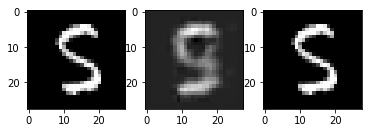

Training
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./models/mnist_denoisingautoencoderall/model.ckpt-8001
INFO:tensorflow:Saving checkpoints for 8002 into ./models/mnist_denoisingautoencoderall/model.ckpt.
INFO:tensorflow:loss = 0.03733605, step = 8002
INFO:tensorflow:global_step/sec: 47.9879
INFO:tensorflow:loss = 0.038543694, step = 8102 (2.085 sec)
INFO:tensorflow:global_step/sec: 52.0035
INFO:tensorflow:loss = 0.040098045, step = 8202 (1.923 sec)
INFO:tensorflow:global_step/sec: 51.4417
INFO:tensorflow:loss = 0.037552685, step = 8302 (1.946 sec)
INFO:tensorflow:global_step/sec: 51.3912
INFO:tensorflow:loss = 0.038212456, step = 8402 (1.944 sec)
INFO:tensorflow:global_step/sec: 51.8511
INFO:tensorflow:loss = 0.037832417, step = 8502 (1.929 sec)
INFO:tensorflow:global_step/sec: 50.593
INFO:tensorflow:loss = 0.03898825, step = 8602 (1.978 sec)
INFO:tensorflow:global_step/sec: 50.8202
INFO:tensorflow:loss = 0.040630184, step = 8702 (1.972 sec

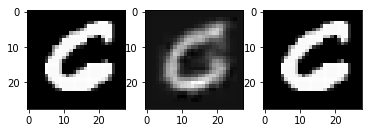

Training
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./models/mnist_denoisingautoencoderall/model.ckpt-9001
INFO:tensorflow:Saving checkpoints for 9002 into ./models/mnist_denoisingautoencoderall/model.ckpt.
INFO:tensorflow:loss = 0.04039356, step = 9002
INFO:tensorflow:global_step/sec: 48.371
INFO:tensorflow:loss = 0.03900322, step = 9102 (2.069 sec)
INFO:tensorflow:global_step/sec: 51.5655
INFO:tensorflow:loss = 0.03896678, step = 9202 (1.939 sec)
INFO:tensorflow:global_step/sec: 51.747
INFO:tensorflow:loss = 0.039769776, step = 9302 (1.934 sec)
INFO:tensorflow:global_step/sec: 50.4041
INFO:tensorflow:loss = 0.039568927, step = 9402 (1.984 sec)
INFO:tensorflow:global_step/sec: 51.1753
INFO:tensorflow:loss = 0.037744343, step = 9502 (1.952 sec)
INFO:tensorflow:global_step/sec: 51.8107
INFO:tensorflow:loss = 0.03976536, step = 9602 (1.930 sec)
INFO:tensorflow:global_step/sec: 51.9293
INFO:tensorflow:loss = 0.038518567, step = 9702 (1.926 sec)
I

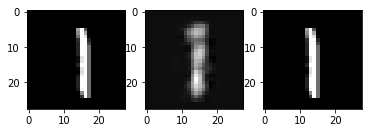

Training
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./models/mnist_denoisingautoencoderall/model.ckpt-10001
INFO:tensorflow:Saving checkpoints for 10002 into ./models/mnist_denoisingautoencoderall/model.ckpt.
INFO:tensorflow:loss = 0.039533857, step = 10002
INFO:tensorflow:global_step/sec: 48.1087
INFO:tensorflow:loss = 0.03991737, step = 10102 (2.080 sec)
INFO:tensorflow:global_step/sec: 51.8477
INFO:tensorflow:loss = 0.03793761, step = 10202 (1.929 sec)
INFO:tensorflow:global_step/sec: 51.625
INFO:tensorflow:loss = 0.03889104, step = 10302 (1.938 sec)
INFO:tensorflow:global_step/sec: 51.5133
INFO:tensorflow:loss = 0.038126107, step = 10402 (1.940 sec)
INFO:tensorflow:global_step/sec: 51.6143
INFO:tensorflow:loss = 0.03906488, step = 10502 (1.938 sec)
INFO:tensorflow:global_step/sec: 50.8169
INFO:tensorflow:loss = 0.03739867, step = 10602 (1.972 sec)
INFO:tensorflow:global_step/sec: 51.3346
INFO:tensorflow:loss = 0.039307058, step = 10702 (1.

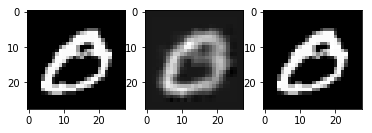

Training
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./models/mnist_denoisingautoencoderall/model.ckpt-11001
INFO:tensorflow:Saving checkpoints for 11002 into ./models/mnist_denoisingautoencoderall/model.ckpt.
INFO:tensorflow:loss = 0.03856005, step = 11002


KeyboardInterrupt: 

In [16]:
print("started\n")
# Train the model
while 1:
    
# Train the model
    print("Training")
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=256,
      num_epochs=None,
      shuffle=True)

    mnist_classifier.train(
      input_fn=train_input_fn,
      steps=1000,
      hooks=None,)
    c = np.random.randint(0,55000)
    current_loss(c)
#     print("Step")
#     if curr_result[0] - curr_result[1] > 0.10 or curr_result[1] > 0.98:
#        break
#     print(curr_result)
    
print ("Finished")

In [30]:
eval_data = SP.load('mnist')[2]
eval_labels = np.copy(eval_data)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [31]:
eval_data = SP.Translation(eval_data,2)
eval_data = SP.Exposure(eval_data,60)

In [32]:
eval_labels = eval_labels.reshape(-1,28,28)
eval_data = eval_data.reshape(-1,28,28)

INFO:tensorflow:Restoring parameters from ./models/mnist_denoisingautoencoderall/model.ckpt-11002


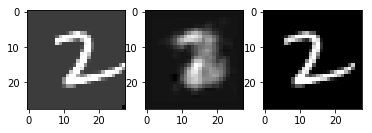

In [36]:
current_loss(919,eval_data,eval_labels)